### Compute equilibrium for the no-aggregate uncertainty KS model: DTCSCC

Proof of concept for computing the equilibrium for the model. Then, using the equilibrium aggregate capital, compute the stationary distribution (and decision rules) and plot them. This version uses a dtcscc model, thereby allowing continuous shocks.

This code does not make use of CompEcon, or rely on linear basis matrices. 

In [3]:
# Setup
import numpy as np
import scipy.sparse as spa

from dolo import *
from dolo.algos.dtcscc.time_iteration import time_iteration
import dolo.algos.dtcscc.distributions as dst
from dolo.numeric.misc import mlinspace
from dolo.numeric.discretization.quadrature import gauss_hermite_nodes

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [4]:
filename = 'incomplete_markets_dtcscc.yaml'
model = yaml_import(filename)

Nf = np.array([200, 20])

### Solve using time iteration and plot decision rules

In [5]:
dr = time_iteration(model, with_complementarities=True, verbose=False) 

    Did not converge


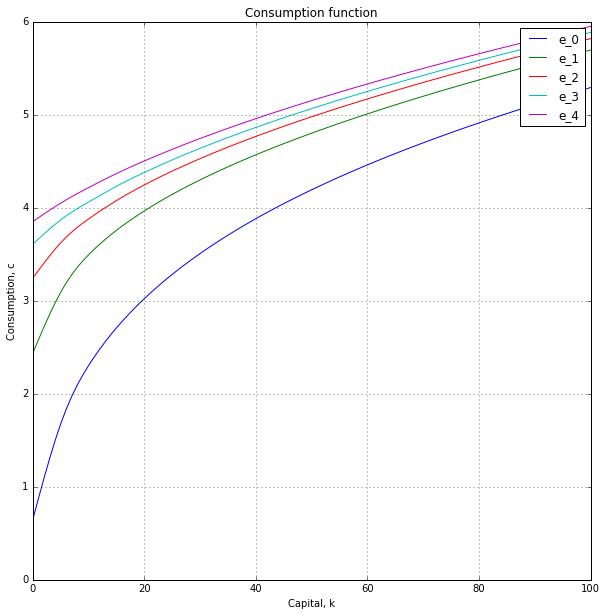

In [13]:
Nk = 100
Nftmp = np.array([Nk,1])
egrid = np.unique(dr.grid[:,1])
Ne = egrid.shape[0]

drc = np.zeros([Nk, Ne])
for i_e in range(Ne):
    sgridf = mlinspace(np.array([min(dr.grid[:,0]), egrid[i_e]]), np.array([max(dr.grid[:,0]), egrid[i_e]]),Nftmp)
    drc[:, i_e] = dr(sgridf).flatten()

%matplotlib inline

plt.figure(figsize=(10, 10))

# TECHNOLOGY SHOCK
plt.plot(sgridf[:,0], drc[:,0],label='e_0')
plt.plot(sgridf[:,0], drc[:,1],label='e_1')
plt.plot(sgridf[:,0], drc[:,2],label='e_2')
plt.plot(sgridf[:,0], drc[:,3],label='e_3')
plt.plot(sgridf[:,0], drc[:,4],label='e_4')
plt.ylabel('Consumption, c')
plt.xlabel('Capital, k')
plt.title('Consumption function')
plt.legend()
plt.grid()

### Compute stationary distribution 

In [14]:
L, QT = dst.stat_dist(model, dr, Nf, Nq=7, itmaxL=5000, tolL=1e-8, verbose=True)

Iteration = 0, dist = 0.447246 

Iteration = 100, dist = 0.000558 

Iteration = 200, dist = 0.000000 



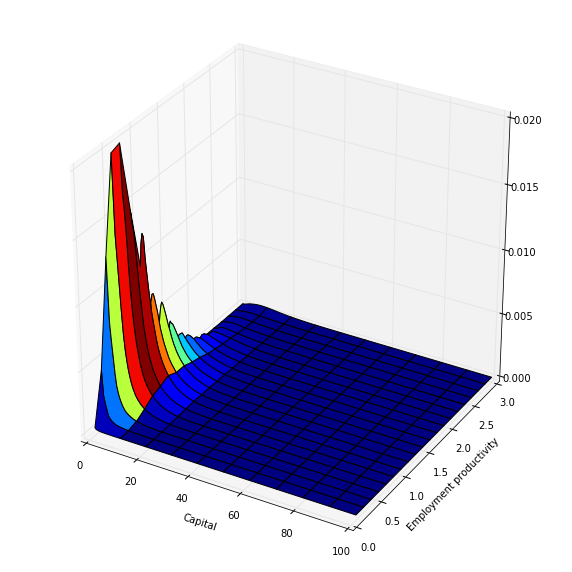

In [15]:
# 3D plot of the distribution
Nkf = Nf[0]
Nef = Nf[1]
Z = L.reshape([Nef, Nkf])
kgridf, egridf = dst.fine_grid(model, Nf)
X, Y = np.meshgrid(kgridf, egridf)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,Z, rstride=1, cstride=20, cmap = cm.jet)
plt.xlabel('Capital')
plt.ylabel('Employment productivity')
# ax.elev = 20
# ax.azim = 200

In [6]:
Kd, Ks, r = dst.supply_demand(model, Nf, numpoints=20, lower=35, upper=75, verbose=True)

    Did not converge
    Maximum number of iterations reached


Iteration = 0

Iteration = 1

Iteration = 2

Iteration = 3

Iteration = 4

Iteration = 5

Iteration = 6

Iteration = 7

Iteration = 8

Iteration = 9

Iteration = 10

Iteration = 11

Iteration = 12

Iteration = 13

Iteration = 14



    There are multiple convergent solutions. The one with the smaller eigenvalues was selected.


Iteration = 15

Iteration = 16

Iteration = 17

Iteration = 18

Iteration = 19



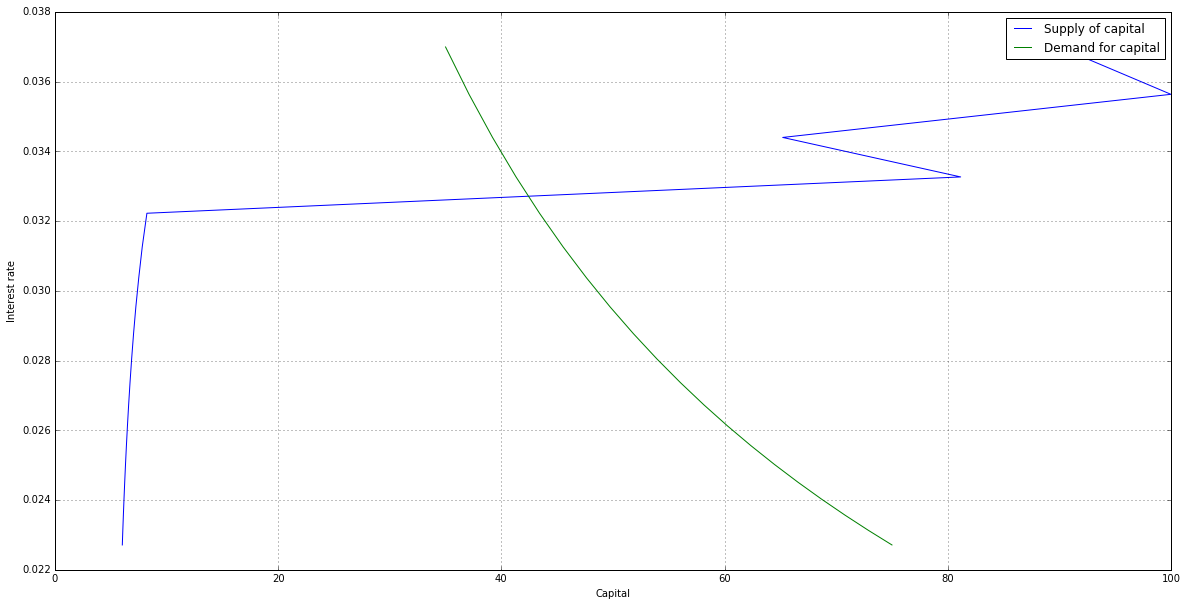

In [7]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
plt.plot(Ks, r,label='Supply of capital')
plt.plot(Kd, r,label='Demand for capital')
# plt.plot((37.9893, 37.9893), (0.031, 0.036), 'k-', color='black', label='RA steady state capital')
plt.xlabel('Capital')
plt.ylabel('Interest rate')
plt.legend()
plt.grid()
# plt.ylim(0.0335, 0.036)
# plt.xlim(20, 60)

### Compute the equilibrium interest rate 

In [3]:
K = dst.solve_eqm(model, Kinit=38, tolKeq=1e-5, verbose=True)

Iteration = 	0: K=	38.0000  Kagg=	98.7978

Iteration = 	1: K=	38.0608  Kagg=	98.5146

Iteration = 	2: K=	38.4232  Kagg=	57.4972

Iteration = 	3: K=	38.6324  Kagg=	39.4280

Iteration = 	4: K=	38.6450  Kagg=	39.0059

Iteration = 	5: K=	38.6525  Kagg=	38.7659

Iteration = 	6: K=	38.6555  Kagg=	38.6748

Iteration = 	7: K=	38.6560  Kagg=	38.6564



### Using equilibrium aggregate capital stock, compute decision rules and stationary distribution

In [4]:
# Set model calibration to the equilibrium aggregate capital stock.
model.set_calibration(kagg=K)

# drc = time_iteration(model, with_complementarities=True, verbose=False, output_type='controls') 
mdr = time_iteration(model, with_complementarities=True, verbose=False, output_type='dr') 

In [5]:
L, QT = dst.stat_dist(model, mdr, Nkf=Nkf, verbose=False)

### Plot the equilibrium stationary distribution and decision rules

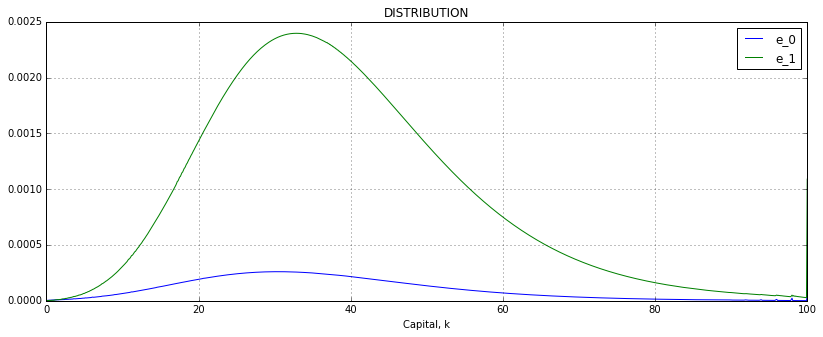

In [6]:
%matplotlib inline

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(kgridf, L[:Nkf],label='e_0')
plt.plot(kgridf, L[Nkf:],label='e_1')
plt.xlabel('Capital, k')
plt.title('DISTRIBUTION')
plt.legend()
plt.grid()

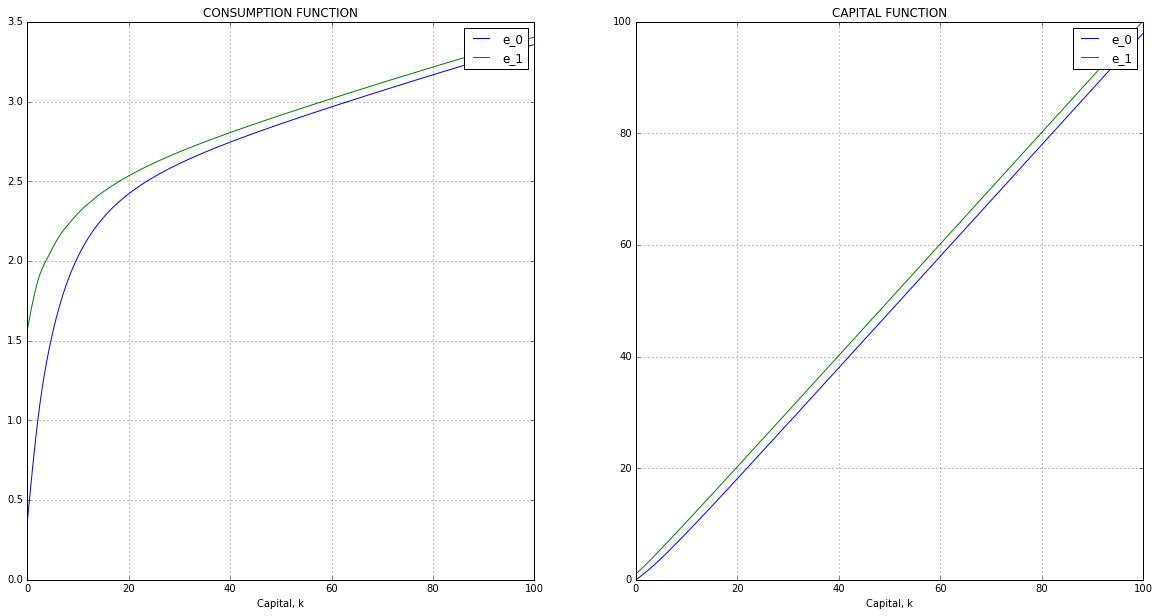

In [9]:
# Get kprime and consumption from the markov decision rule

kprimef = dst.mdr_to_sprime(model, mdr, Nkf)
mdrc = np.zeros([Nkf, Ne])
for i_m in range(Ne):
    mdrc[:, i_m] = mdr(i_m, kgridf.reshape(-1,1)).flatten()

# Plot controls

%matplotlib inline
kgrid = mdr.grid

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.plot(kgridf, mdrc[:,0],label='e_0')
plt.plot(kgridf, mdrc[:,1],label='e_1')
plt.xlabel('Capital, k')
plt.title('CONSUMPTION FUNCTION')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(kgridf, kprimef[:Nkf],label='e_0')
plt.plot(kgridf, kprimef[Nkf:],label='e_1')
plt.xlabel('Capital, k')
plt.title('CAPITAL FUNCTION')
plt.legend()
plt.grid()

### Compute supply and demand curves using stat_dist function

In [ ]:
Kd, Ks, r = dst.supply_demand(model, Nkf=1000, numpoints=20, lower=37, upper=40, verbose=True)

(20, 60)

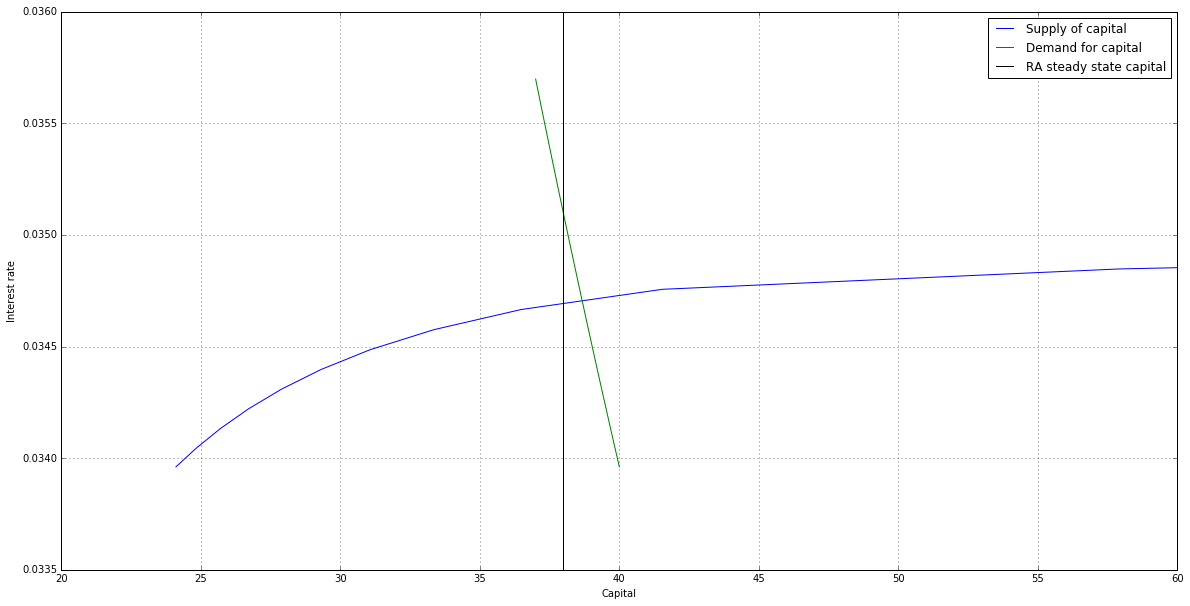

In [4]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
plt.plot(Ks, r,label='Supply of capital')
plt.plot(Kd, r,label='Demand for capital')
plt.plot((37.9893, 37.9893), (0.031, 0.036), 'k-', color='black', label='RA steady state capital')
plt.xlabel('Capital')
plt.ylabel('Interest rate')
plt.legend()
plt.grid()
plt.ylim(0.0335, 0.036)
plt.xlim(20, 60)

#### Create a function that takes transition back to control

For models in which we can use the $s_{t+1}$ trick, need to create a function that takes this transition rule back to the control. 